In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv("Merged_Gold_dataset.csv")

df.head()

,Unnamed: 0,Date,Close,High,Low,Open,Volume,RSI,SMA10,SMA20,CPIAUCSL,CIVPART,GDP,GEPUCURRENT,PPIACO,UNRATE,CLI,GDP_Reference
0,0,2005-03-28,425.899994,425.899994,425.899994,425.899994,0,33.386323,434.190002,435.730000,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
1,1,2005-03-29,426.000000,426.000000,426.000000,426.000000,0,33.629056,432.680002,435.205000,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
2,2,2005-03-31,428.700012,428.700012,428.700012,428.700012,3051,39.987248,431.460004,434.995001,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
3,3,2005-04-01,425.899994,428.500000,424.500000,428.299988,552,36.122564,429.680002,434.650002,193.7,66.1,12922.656,68.682759,155.0,5.2,100.2931,100.5254
4,4,2005-04-04,423.899994,426.299988,422.700012,426.000000,486,33.622901,428.200000,434.350002,193.7,66.1,12922.656,68.682759,155.0,5.2,100.2931,100.5254


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

df['High_Low_Spread'] = df['High'] - df['Low']
df['Open_Close_Change'] = df['Close'] - df['Open']
df['Volatility'] = (df['High'] - df['Low']) / df['Open']

y = df['Close']

features = ['Open_Close_Change', 'Low', 'High', 'High_Low_Spread','Open', 'RSI', 'Volatility']

X = df[features]
y = df['Close']


In [ ]:
X_train = X.iloc[0:3756]
X_test = X.iloc[3756:]
y_train = y.iloc[0:3756]
y_test = y.iloc[3756:]


In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 7
[LightGBM] [Info] Start training from score 1154.035357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
              n_estimators=500, random_state=42, subsample=0.8)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test))
accuracy = 1 - mape
r2 = r2_score(y_test, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

MAPE: 0.0800
Accuracy: 0.9200
RMSE: 332.9941
R2 Score: -0.2507


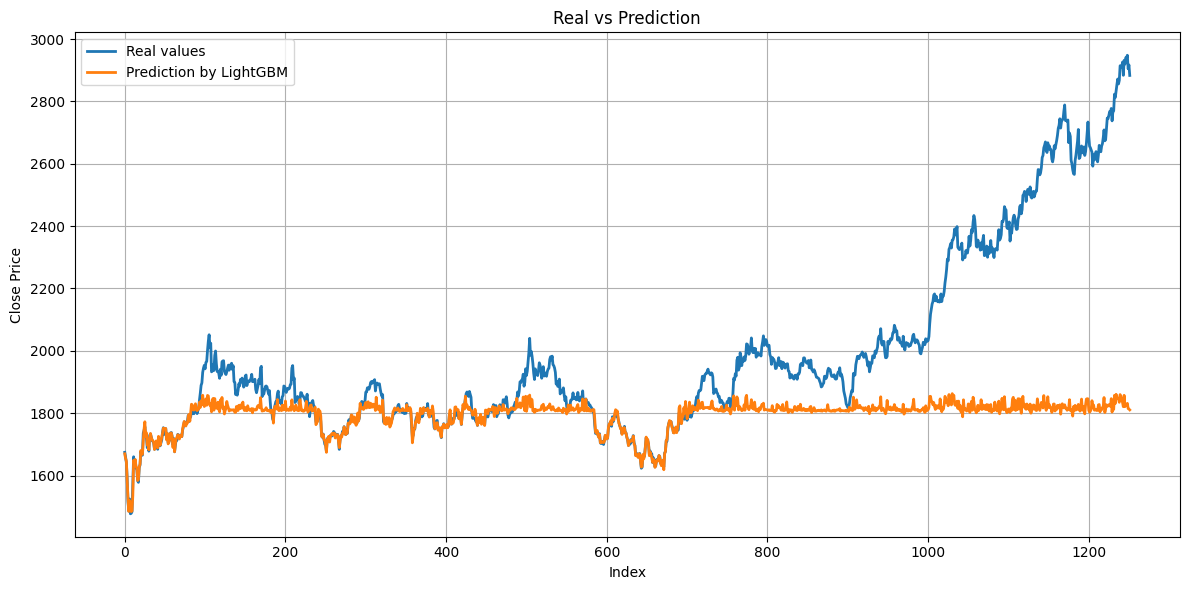

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Real values', linewidth=2)
plt.plot(y_pred, label='Prediction by LightGBM', linewidth=2)
plt.title("Real vs Prediction")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Why we choose those features

We kept variables like Open, High, Low, RSI, and Open_Close_Change because they represent how the market behaves within a single day — including price direction and momentum.


We used LightGBM feature importance to identify the most predictive variables. Features like Open_Close_Change, Low, High, and RSI were among the top.

We also included High_Low_Spread and Volatility to give the model a better understanding of intraday movement and market variability.

We chose to exclude weaker features such as DayOfWeek, Month, Year, and macro indicators like GDP and CPI, since they didn’t improve results and added unnecessary noise.

You can execute the code below to see the graph:

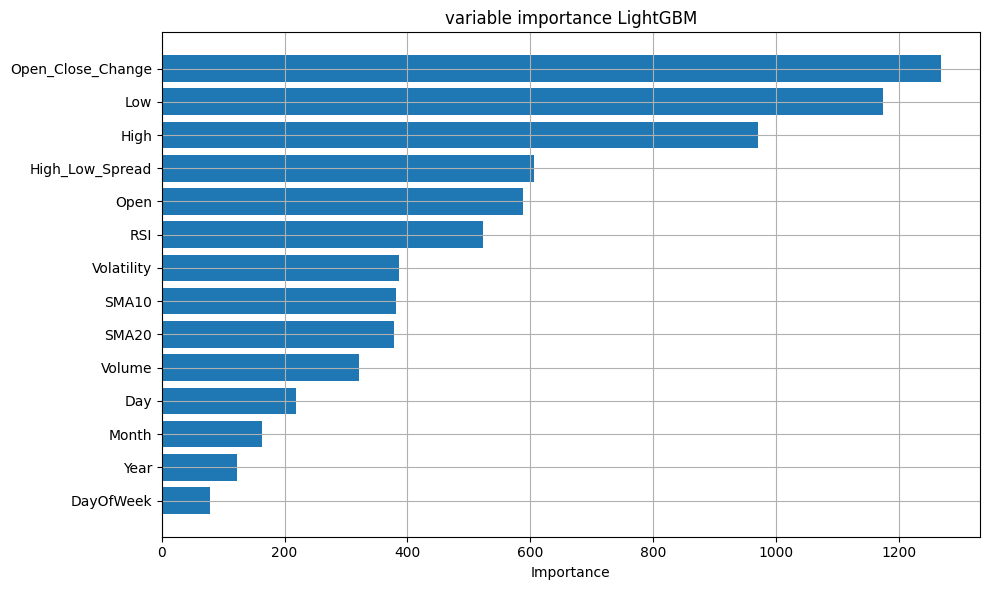

,Feature,Importance
0,Open_Close_Change,1269
1,Low,1175
2,High,971
3,High_Low_Spread,606
4,Open,588
5,RSI,523
6,Volatility,387
7,SMA10,381
8,SMA20,378
9,Volume,321


In [ ]:
importances = model.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.xlabel("Importance")
plt.title("variable importance LightGBM")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

feat_df.reset_index(drop=True)
